In [1]:
import os
import numpy as np

BASE_PATH = '/home/mgraca/Workspace/hrrr-smoke-viz'
DATA_PATH = os.path.join(BASE_PATH, 'pwwb-experiments/tensorflow/basic-cnn-archive/training-data')
RESULTS_PATH = os.path.join(BASE_PATH, 'pwwb-experiments/tensorflow/basic-cnn-archive/results')

In [2]:
X_train = np.load(os.path.join(DATA_PATH, 'X_train.npy'))
X_valid = np.load(os.path.join(DATA_PATH, 'X_valid.npy'))
X_test = np.load(os.path.join(DATA_PATH, 'X_test.npy'))
Y_train = np.load(os.path.join(DATA_PATH, 'Y_train.npy'))
Y_valid = np.load(os.path.join(DATA_PATH, 'Y_valid.npy'))
Y_test = np.load(os.path.join(DATA_PATH, 'Y_test.npy'))

# initially fit data for conv3d, but should squeeze out the frame dimension
X_train = np.squeeze(X_train)
X_valid = np.squeeze(X_valid)
X_test = np.squeeze(X_test)
Y_train = np.squeeze(Y_train)
Y_valid = np.squeeze(Y_valid)
Y_test = np.squeeze(Y_test)

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(12279, 40, 40, 14) (12279, 40, 40)
(2631, 40, 40, 14) (2631, 40, 40)
(2631, 40, 40, 14) (2631, 40, 40)


In [3]:
input_shape = X_train.shape[1:]
air_sens_loc = {
    'Reseda' : (8, 3),
    'North Holywood' : (8, 11),
    'Los Angeles - N. Main Street' : (15, 16),
    'Compton' : (23, 17),
    'Long Beach Signal Hill' : (29, 19),
    'Anaheim' : (27, 29),
    'Glendora - Laurel' : (10, 33)
}

print(input_shape)

(40, 40, 14)


In [4]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Input, Reshape
'''
from keras.models import Model
from keras.layers import Conv3D, Conv2D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization, LayerNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape, GlobalAveragePooling2D
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer
'''
tf.keras.backend.set_image_data_format('channels_last')

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(filters=15, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=30, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=15, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=1, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Reshape((input_shape[0], input_shape[1])))

model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam())

model.summary()

2025-12-02 12:19:03.924944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 12:19:03.931609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764706743.939962   18571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764706743.942709   18571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764706743.948907   18571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 40, 15)     │         1,905 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 30)     │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 15)     │         4,065 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 1)      │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 40, 40)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,186 (39.79 KB)

 Trainable params: 10,186 (39.79 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_valid, Y_valid)
)

Epoch 1/100


I0000 00:00:1764706747.218912   18680 service.cc:152] XLA service 0x7c8620004cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764706747.218940   18680 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-12-02 12:19:07.232158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764706747.321963   18680 cuda_dnn.cc:529] Loaded cuDNN version 91002


 82/192 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8193

I0000 00:00:1764706748.096831   18680 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7572 - val_loss: 1.6476
Epoch 2/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2501 - val_loss: 1.4184
Epoch 3/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0905 - val_loss: 1.3180
Epoch 4/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0417 - val_loss: 1.2350
Epoch 5/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0317 - val_loss: 1.2717
Epoch 6/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0065 - val_loss: 1.1852
Epoch 7/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9868 - val_loss: 1.1911
Epoch 8/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9911 - val_loss: 1.2034
Epoch 9/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9835 - val_loss: 1.1603
Epoch 10/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9791 - val_loss: 1.1575
Epoch 11/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9759 - val_loss: 1.1826
Epoch 12/100
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

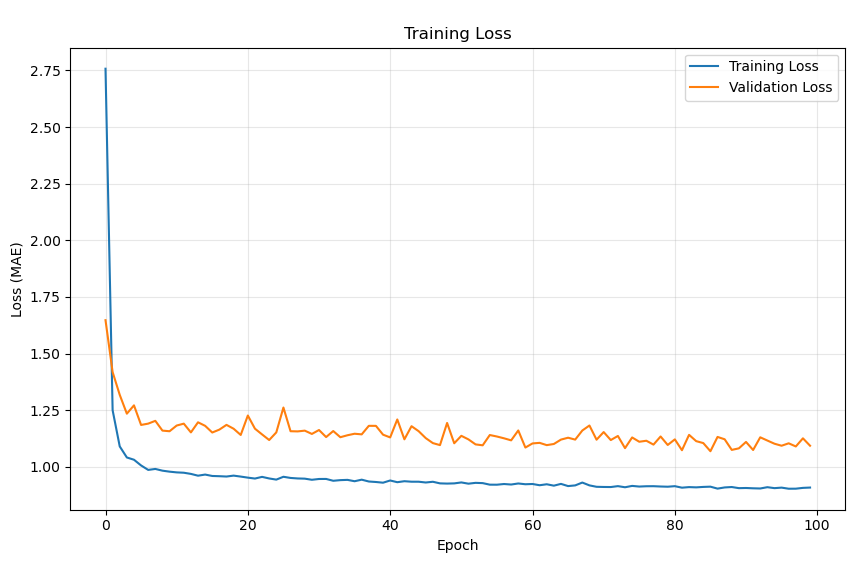

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Evaluate model
y_pred = model.predict(X_test, verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [7]:
np.save(os.path.join(RESULTS_PATH, 'Y_pred.npy'), y_pred)

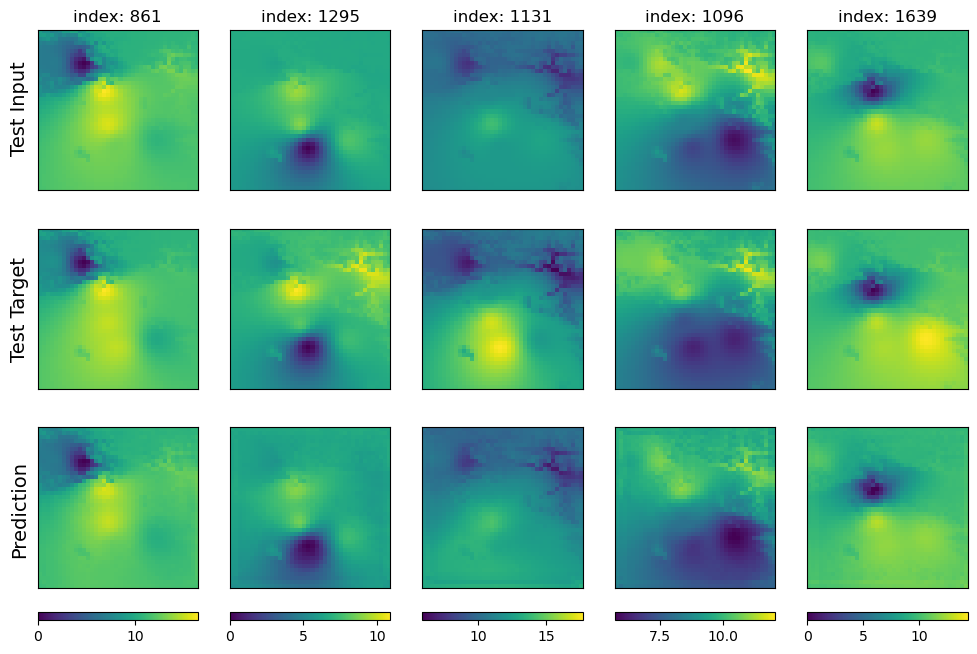

In [9]:
np.random.seed(42)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(12, 8))

for c in range(axes.shape[1]):
    idx = np.random.randint(1, len(Y_test))
    vmin = np.nanmin([Y_test[idx], y_pred[idx], Y_test[idx-1]])
    vmax = np.nanmax([Y_test[idx], y_pred[idx], Y_test[idx-1]])
    
    axes[0, c].imshow(Y_test[idx-1], vmin=vmin, vmax=vmax)
    axes[0, c].set_title(f'index: {idx}')
    axes[0, c].set_xticks([])
    axes[0, c].set_yticks([])
    
    axes[1, c].imshow(Y_test[idx], vmin=vmin, vmax=vmax)
    axes[1, c].set_xticks([])
    axes[1, c].set_yticks([])

    im = axes[2, c].imshow(y_pred[idx], vmin=vmin, vmax=vmax)
    axes[2, c].set_xticks([])
    axes[2, c].set_yticks([])

    fig.colorbar(im, ax=axes[:, c], orientation='horizontal', fraction=0.046, pad=0.04)
    
fig.text(0.11, 0.775, 'Test Input', rotation=90, va='center', ha='center', fontsize=14)
fig.text(0.11, 0.525, 'Test Target', rotation=90, va='center', ha='center', fontsize=14)
fig.text(0.11, 0.275, 'Prediction', rotation=90, va='center', ha='center', fontsize=14)
plt.show()